# Modelo 2 - LGBM - Processamento individual

In [41]:
import re
from collections import Counter
import sklearn as skl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.metrics import classification_report,plot_confusion_matrix, accuracy_score, precision_score, recall_score
from lightgbm import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectFromModel

In [42]:
incidentes = pd.read_csv("../input/train_data_cleaned.csv", index_col=0)
teste = pd.read_csv("../input/test_data_cleaned.csv", index_col=0)

## 1 - Tratar Outliers

In [43]:
# função que determina se uma coluna está desviada e que a transforma conforme o caso
def check_and_transform_skewness(column_list,df):
  for col in column_list:
    skewness = df[col].skew()
    print(f'Initial skewness: {skewness}')
    if -1 < skewness < 1:
      df[col] = np.log1p(df[col])
      print(f'High skewness: {df[col].skew()}')
      print("Done")
    elif -0.3 < skewness < -1 or 0.3 < skewness < 1:
      df[col] = np.log1p(df[col])
      print(f'Moderate skewness: {df[col].skew()}')
      print("Done")
    elif -0.3 < skewness < 0.3:
      print(f"column \'{col}\' is fairly skewed.")
    return df

In [44]:
# dados, lista de colunas, flg com método de deteção, method = string com a forma de os substituir.
def process_outliers(df, columns, flag, method):
    if flag == 1:
        # Use IQR distance to detect outliers
        for col in columns:
            median = df[col].median()
            lower_quartile = df[col].quantile(0.25)
            upper_quartile = df[col].quantile(0.75)
            iqr = upper_quartile - lower_quartile

            # Find the rows with outliers
            outliers = df[(df[col] < lower_quartile - 1.5 * iqr) | (df[col] > upper_quartile + 1.5 * iqr)]
            indices = outliers.index
            #outliers_per = len(outliers)/len(df[col] * 100)

            # Process the outliers according to the specified method
            if method == "remove":
                df = df.drop(indices)
            elif method == "median":
                df.loc[indices, col] = median
            elif method == "mode":
                df.loc[indices, col] = df[col].mode()[0]
            elif method == "mean":
                df.loc[indices, col] = df[col].mean()
    elif flag == 2:
        # Use MAD to detect outliers
        for col in columns:
            median = df[col].median()
            mad = np.mean(np.abs(df[col] - median))

            # Find the rows with outliers
            outliers = df[(df[col] - median).abs() > 3*mad]
            indices = outliers.index

            # Process the outliers according to the specified method
            if method == "remove":
                df = df.drop(indices)
            elif method == "median":
                df.loc[indices, col] = median
            elif method == "mode":
                df.loc[indices, col] = df[col].mode()[0]
            elif method == "mean":
                df.loc[indices, col] = df[col].mean()
    else:
        raise ValueError("Invalid flag. Must be 1 (IQR) or 2 (MAD).")

    return df

In [45]:
not_skewed_columns = ['avg_temperature']
skewed_columns = ['delay_in_seconds', 'avg_atm_pressure','avg_humidity']

# tratar as desviadas com log transform
print("Trabalho nos dados de treino ...")
incidentes_transformed = check_and_transform_skewness(skewed_columns, incidentes)
print("Trabalho nos dados de teste ...")
teste_transformed = check_and_transform_skewness(skewed_columns, teste)
print("Done.")

Trabalho nos dados de treino ...
Initial skewness: 6.274560871857796
Trabalho nos dados de teste ...
Initial skewness: 4.866904832456009
Done.


In [46]:
incidentes_media = incidentes_transformed.copy()
incidentes_media = process_outliers(incidentes_media,not_skewed_columns,1,"mean")

## Modelo

In [47]:
x_media = incidentes_media.drop(['incidents'], axis=1)
y_media = incidentes_media['incidents']

In [48]:
X_train, X_test, y_train, y_test = train_test_split(x_media, y_media, test_size=0.25, random_state=42)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       517
           1       0.88      0.93      0.91       189
           2       0.86      0.81      0.84       144
           3       0.93      0.90      0.92       265
           4       0.91      0.96      0.93       135

    accuracy                           0.94      1250
   macro avg       0.92      0.92      0.92      1250
weighted avg       0.94      0.94      0.94      1250

0.94


/home/purp/anaconda3/envs/dataset_COMPETICAO/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


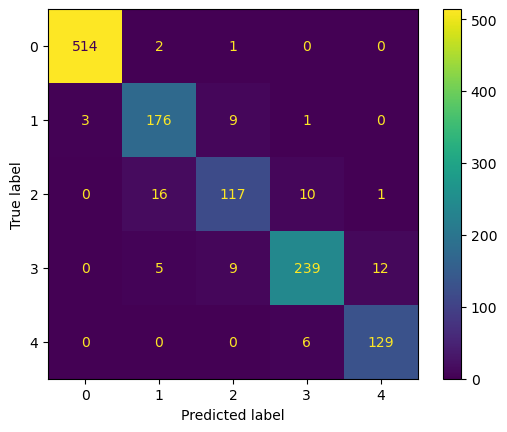

In [49]:
lgb_model = LGBMClassifier(boosting_type='gbdt', learning_rate=0.1, n_estimators=100, random_state=42)
lgb_model.fit(X_train, y_train)
lgb_pred = lgb_model.predict(X_test)
print(classification_report(y_test,lgb_pred))
plot_confusion_matrix(lgb_model,X_test,y_test)
plt.show
print(accuracy_score(y_test, lgb_pred))

In [50]:
# gera o dataset a submeter na competição
def gerar_submissao(predictions):
    #gerar submissão
    submission = pd.DataFrame(predictions, columns = ["Incidents"])
    submission.insert(0, "RowId", range(1,1207), True)
    submission["Incidents"] = submission['Incidents'].replace({0 : 'None', 1 : 'Low', 2 : 'Medium', 3 : 'High', 4 : 'Very_High'}).astype(str)
    submission.to_csv('../output/submission.csv',index=False)
    print("Exported.")

In [51]:
#test_pred = rf_model.predict(teste)
#gerar_submissao(test_pred)

## 2. Normalização - (0,1)


* Pretendemos fazer Feature Selection, apesar de, intuitivamente já termos feito algum;
* Vamos explorar os diferentes métodos conhecidos de normalização, relevante ser feita antes de feature selection, até porque, um dos métodos mais conhecidos, utiliza algoritmos que funcionam melhor com dados normalizados;
* Então, nesta secção, trata-se apenas normalização;
* Dado que o tratamento de outliers não apresentou melhorias em termos de previsão, descartamos esse tratamento e voltamos ao tratamento anterior, com presença de outliers. A boa notícia é a existência de formas de normalização que acabam por reduzir o impacto destes outliers, o que pode melhorar o desempenho do modelo (como é o caso da transformação logarítmica, como veremos);
* A ideia é, então, observar cada feature antes e depois desta normalização, percebendo como cada tipo funciona e se contribui ou não para obtenção de melhores métricas;
* De forma resumida existem 3 tipos de normalização [1]:
    * Normalizar num intervalo, normalmente entre 0 e 1;
        * Resulta bem com:
            * Distribuição normal de dados;
            * Há intuitivamente uma barreira superior/inferior nos dados;
    * Feature Clipping, que remove todos os valores abaixo/acima de um intervalo;
        * Resulta bem com:
            * Existência de muitos outliers extremos (selecionar o intervalo de acordo com os outliers);
            * Pode ser aplicada antes ou depois de outras normalizações;
    * Transformação Log., transforma os valores no seu logaritmo;        
        * Resulta bem com:
            * Distribuição não normal de dados (skewness);
            * Há muitas ocorrências de uma certa classe e poucas de outra;

[1] https://developers.google.com/machine-learning/data-prep/transform/normalization

In [52]:
dict_scalers = {}

scaler = MinMaxScaler()
min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0,1))

incidentes_norm = incidentes_media.copy()
teste_norm = teste_transformed.copy()
columns = list(incidentes_norm.columns)
columns.remove('incidents')
print(columns)

# fazemos o fit, guardamos o scaler da coluna, aplicamos ao teste
# assim podemos fazer o inverse_transform se necessário, depois.
for col in columns:
    # fit
    scaler_col = min_max_scaler.fit(incidentes_norm[[col]])
    # transform
    incidentes_norm[[col]] = min_max_scaler.transform(incidentes_norm[[col]])
    # guardar scaler no dict
    dict_scalers[col] = scaler_col
    teste_norm[[col]] = dict_scalers.get(col).transform(teste_norm[[col]])

['magnitude_of_delay', 'delay_in_seconds', 'luminosity', 'avg_temperature', 'avg_atm_pressure', 'avg_humidity', 'avg_wind_speed', 'avg_rain', 'National', 'Regional', 'day_of_month', 'week_day', 'month', 'hour', 'day_of_year', 'season', 'is_holiday', 'is_weekend']


In [53]:
incidentes_norm.head()

,magnitude_of_delay,delay_in_seconds,luminosity,avg_temperature,avg_atm_pressure,avg_humidity,avg_wind_speed,avg_rain,incidents,National,Regional,day_of_month,week_day,month,hour,day_of_year,season,is_holiday,is_weekend
0,0.0,0.000000,0.0,0.407407,0.457143,0.680851,0.1,0.0,0,0.000000,0.000000,0.466667,0.000000,0.181818,1.000000,0.166189,0.000000,0.0,0.0
1,0.0,0.012386,0.0,0.407407,0.285714,0.904255,0.1,0.0,0,0.023810,0.000000,0.800000,0.833333,1.000000,0.782609,0.982808,1.000000,1.0,0.0
2,0.0,0.002220,1.0,0.481481,0.800000,0.617021,0.0,0.0,1,0.000000,0.000000,0.366667,0.666667,0.181818,0.652174,0.157593,0.000000,0.0,0.0
3,1.0,0.073899,1.0,0.518519,0.885714,0.734043,0.1,0.0,4,0.238095,0.166667,0.933333,0.333333,0.727273,0.391304,0.733524,1.000000,0.0,0.0
4,0.0,0.000000,1.0,0.962963,0.657143,0.489362,0.1,0.0,3,0.119048,0.000000,0.400000,1.000000,0.454545,0.478261,0.424069,0.333333,0.0,0.0


### Segunda avaliação do modelo com normalização

In [54]:
#divisão do target
x_norm = incidentes_norm.drop(['incidents'], axis=1)
y_norm = incidentes_norm['incidents']

In [55]:
X_train, X_test, y_train, y_test = train_test_split(x_norm, y_norm, test_size=0.25, random_state=42)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       517
           1       0.90      0.93      0.92       189
           2       0.87      0.83      0.85       144
           3       0.92      0.90      0.91       265
           4       0.90      0.93      0.92       135

    accuracy                           0.94      1250
   macro avg       0.92      0.92      0.92      1250
weighted avg       0.94      0.94      0.94      1250

0.9392


/home/purp/anaconda3/envs/dataset_COMPETICAO/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


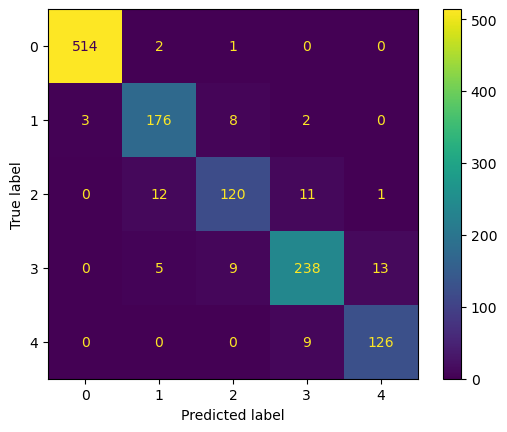

In [56]:
lgb_model_norm = LGBMClassifier(boosting_type='gbdt', learning_rate=0.1, n_estimators=100, random_state=42)
lgb_model_norm.fit(X_train, y_train)
lgb_pred_norm = lgb_model_norm.predict(X_test)
print(classification_report(y_test,lgb_pred_norm))
plot_confusion_matrix(lgb_model_norm,X_test,y_test)
plt.show
print(accuracy_score(y_test, lgb_pred_norm))

Piorou.

#### Avaliação com Cross-Validation

In [57]:
# Perform 5-fold cross-validation
scores = cross_val_score(lgb_model, x_media, y_media, cv=5, scoring='accuracy')

# Print the mean and standard deviation of the scores
print(f'Mean accuracy: {scores.mean():.2f}')
print(f'Standard deviation: {scores.std():.2f}')

Mean accuracy: 0.94
Standard deviation: 0.00


In [61]:
y_pred_test = lgb_model.predict(teste_transformed)

In [62]:
gerar_submissao(y_pred_test)

Exported.


In [63]:
incidentes_media.to_csv("../input/train_data_outliers_cleaned.csv")
teste_transformed.to_csv("../input/test_data_outliers_cleaned.csv")

Vamos, então, realizar, o tuning do modelo.

Seguir para o notebook 5.1